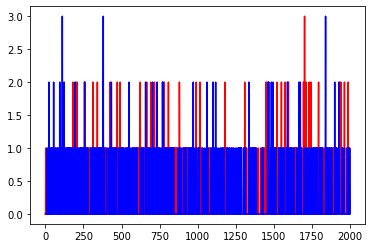

In [1]:
import matplotlib.pyplot as plt
from random import gauss, uniform

from palantir.clock import Clock
from palantir.ithil import Ithil
from palantir.metrics import (
    Metric,
    MetricsAggregatorSum,
    MetricsLogger,
    make_timeseries,
)
from palantir.oracle import PriceOracle
from palantir.palantir import Palantir
from palantir.simulation import Simulation
from palantir.trader import Trader
from palantir.types import (
    Account,
    Currency,
)
from palantir.util import (
    init_price_db,
    make_trader_names,
    read_quotes_from_db,
)


def run_simulation():
    hours = 2000
    tokens = [
        Currency("bitcoin"),
        Currency("ethereum"),
        Currency("dai"),
    ]

    db = init_price_db(tokens, hours)

    def build_simulation():
        TRADERS_NUMBER = 10
        TRADER_NAMES = make_trader_names(TRADERS_NUMBER)

        clock = Clock(hours)

        DESIRED_MAX_SLIPPAGE_PERCENT = 1.0
        GAUSS_RANDOM_SLIPPAGE = lambda price: gauss(
            price, price * DESIRED_MAX_SLIPPAGE_PERCENT / 100.0
        )

        metrics_logger = MetricsLogger(clock)
        price_oracle = PriceOracle(
            clock=clock,
            quotes={
                token: read_quotes_from_db(db, token, hours) for token in tokens
            },
        )
        ithil = Ithil(
            apply_slippage=GAUSS_RANDOM_SLIPPAGE,
            calculate_fees=lambda _: 0.0,
            calculate_interest_rate=lambda _src_token, _dst_token, _collateral, _principal: 0.0,
            calculate_liquidation_fee=lambda _: 0.0,
            clock=clock,
            insurance_pool={
                Currency("bitcoin"): 0.0,
                Currency("dai"): 0.0,
                Currency("ethereum"): 0.0,
            },
            metrics_logger=metrics_logger,
            price_oracle=price_oracle,
            split_fees=lambda fees: (fees / 2.0, fees / 2.0),
            vaults={
                Currency("bitcoin"): 7.0,
                Currency("dai"): 750000.0,
                Currency("ethereum"): 300.0,
            },
        )
        simulation = Simulation(
            clock=clock,
            ithil=ithil,
            traders=[
                Trader(
                    account=Account(trader_name),
                    open_position_probability=0.1,
                    close_position_probability=0.1,
                    ithil=ithil,
                    calculate_collateral_usd=lambda token: (
                        abs(gauss(mu=3000, sigma=5000)) + 100.0
                    )
                    / price_oracle.get_price(token),
                    calculate_leverage=lambda: uniform(1.0, 10.0),
                    liquidity={
                        Currency("bitcoin"): 0.0,
                        Currency("dai"): 1000.0,
                        Currency("ethereum"): 1.0,
                    },
                )
                for trader_name in TRADER_NAMES
            ],
        )
        
        return simulation
    
    palantir = Palantir(
        simulation_factory=build_simulation,
        simulations_number=2,
    )
    
    simulations_metrics = palantir.run()
    
    opened_positions = [
        make_timeseries(
            metrics,
            Metric.POSITION_OPENED,
            MetricsAggregatorSum(),
            hours,
        )
        for metrics in simulations_metrics
    ]
    
    samples0 = [sample for sample in opened_positions[0]]
    samples1 = [sample for sample in opened_positions[1]]
    plt.plot(samples0, "r-")
    plt.plot(samples1, "b-")
    plt.show()

run_simulation()